### Mateusz Kądziela, 148271
### Mateusz Serek, 148284
Source code and more readable pseudocode available [here](https://github.com/MatKadd/EC_2023/tree/main/lab8).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from utils import calculate_distances, evaluate_solution
from algorithms import get_edge_neigh, get_random_solution, greedy, steepest, perturb

# Read data and calculate distances

In [3]:
C = pd.read_csv("../data/TSPC.csv", sep=";", header=None)
C.name = "Instance C"

instances = [C]

In [4]:
distances = calculate_distances(C)

# Create 1000 random solutions and run greedy local search on them

In [5]:
def local_search(solution, neigh_type, search_type, distances):
    while True:
        neigh = neigh_type(solution)
        solution, improvement = search_type(solution, neigh, distances)
        if improvement == 0:
            break
    return solution

In [6]:
def generate_solutions(start_solution, neigh_type, distances, n=1000):
    start_solutions = [start_solution(start_node=_) for _ in range(n)]
    final_solutions = []
    for solution in start_solutions:
        final_solution = local_search(solution, neigh_type, greedy, distances)
        final_solutions.append((final_solution, evaluate_solution(final_solution, distances)))
    return final_solutions

# Create best solution using iterative local search.

In [18]:
def ILS(start_solution, neigh_type, perturbation, distances):
    start = time.perf_counter()
    solution = start_solution()
    solution = local_search(solution, neigh_type, steepest, distances)
    while (time.perf_counter()-start < 15):
        new_solution = perturbation(solution, distances)
        solution = local_search(new_solution, neigh_type, steepest, distances)
    return solution, evaluate_solution(solution, distances)

In [8]:
solutions = generate_solutions(get_random_solution, get_edge_neigh, distances)

In [14]:
scores = [solution[1] for solution in solutions]

In [19]:
best_score = 1e9
best_solution = None
for i in range(20):
    solution = ILS(get_random_solution, get_edge_neigh, perturb, distances)
    if solution[1] < best_score:
        best_solution = solution
        best_score = solution[1]

# Transform solutions into sets of edges and nodes they contain.

In [22]:
def get_edges(solution):
    edges = set()
    for i in range(len(solution)):
        edges.add(f"{solution[i]}-{solution[(i+1)%100]}")
    return edges

In [23]:
def get_nodes(solution):
    return set(solution)

In [25]:
edges = [get_edges(solution[0]) for solution in solutions]
nodes = [get_nodes(solution[0]) for solution in solutions]

# Calculate similarities

In [56]:
def calculate_similarities(solutions, best_solution=None):
    if best_solution == None:
        average_sims = []
        for i in range(len(solutions)):
            total = 0
            for j in range(len(solutions)):
                if i == j:
                    continue
                total += len(solutions[i].intersection(solutions[j]))
            average = total / len(solutions)
            average_sims.append(average)
        return average_sims
        
    else:
        best_sims = []
        for i in range(len(solutions)):
            sim = len(solutions[i].intersection(best_solution))
            best_sims.append(sim)
        return best_sims

In [57]:
best_nodes = get_nodes(best_solution[0])
best_edges = get_edges(best_solution[0])

In [58]:
average_nodes_sim = calculate_similarities(nodes)
average_edges_sim = calculate_similarities(edges)
best_nodes_sim = calculate_similarities(nodes, best_nodes)
best_edges_sim = calculate_similarities(edges, best_edges)

In [69]:
def create_graph(x, y, title):
    correlation = np.corrcoef(x, y)[0][1]
    plt.scatter(x, y, s=5)
    plt.xlabel("Value of objective function")
    plt.ylabel("Average similarity in %")
    plt.title(title)
    plt.show()
    print(f"Correlation coefficient: {correlation}")

# Plot similarities and correlation coefficients

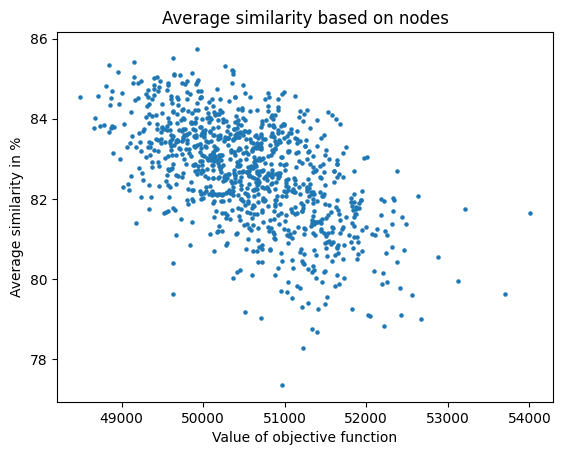

Correlation coefficient: -0.5581694519021453


In [70]:
create_graph(scores, average_nodes_sim, 'Average similarity based on nodes')

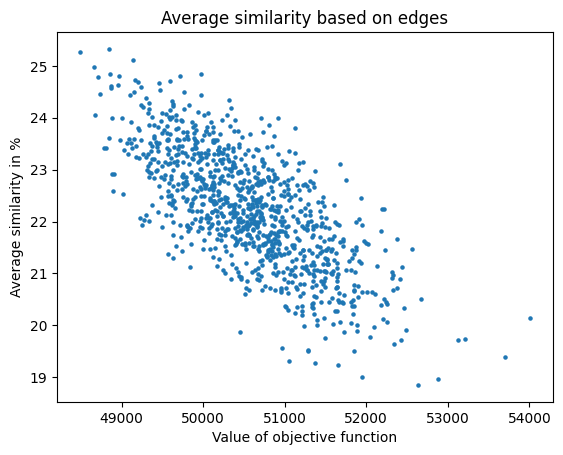

Correlation coefficient: -0.7218011826138727


In [71]:
create_graph(scores, average_edges_sim, 'Average similarity based on edges')

In [72]:
create_graph(scores, best_nodes_sim, 'Similarity to the best solution based on edges')

Correlation coefficient: -0.4286273081744321


In [73]:
create_graph(scores, best_edges_sim, 'Similarity to the best solution based on edges')

Correlation coefficient: -0.14090606960704322
